In [1]:
import os
import matplotlib.pyplot as plt
import pickle
import math
import pandas as pd
import numpy as np

import geopandas as gpd
import rasterio
from affine import Affine
from rasterio.plot import plotting_extent

from scipy import stats
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import RobustScaler
from skimage.segmentation import mark_boundaries
from skimage.segmentation import slic

from arsenic_rs import clusterfunctions
from arsenic_rs import gisfunctions
from arsenic_rs import arsenicmetrics


In [2]:
def scale_minmax (img):

    for i in range(img.shape[2]):
        img[:,:,i] = (img[:,:,i] - np.nanmin(img[:,:,i]))/(np.nanmax(img[:,:,i]) - np.nanmin(img[:,:,i]))
    return img

def fromarraytodataframe(dataarray, colnames = None):
    '''transform rasterio array to pandas dataframe'''
    shape_data = dataarray.shape
    if shape_data[0] > shape_data[2]:
        dataarray = dataarray.swapaxes(1,2)
        dataarray = dataarray.swapaxes(0,1)
        
    dataflat = []
    for i in range(dataarray.shape[0]):
        dataflat.append(dataarray[i,:].ravel())
    
    if colnames is None:
        
        dataflatten = pd.DataFrame(np.array(dataflat).T)
    else:
        dataflatten = pd.DataFrame(np.array(dataflat).T,columns= colnames)
    return dataflatten



## Vegetation indexes for Bangladesh

The Google Earth Engine platform was used to process and download Sentinel-2 data for two different regions located in Bangladesh. Two vegetation indexes were computed using the spectral band reflectance from the Sentinel-2 satellite. The Normalised Difference Vegetation Index (NDVI) that has been widely used for monitoring plant health, and the second one was the Normalized Difference Red Edge (NDRE) that has been recently applied to detect stress in crops using the red edge spectrum .

<br>
$$ NDVI \ = \frac{\ NIR\ -\ RED }{\ NIR\ +\ RED } $$ 

<br>
$$ NDRE \ = \frac{\ rededge_{3}\ -\ rededge_{1}}{\ rededge_{3}\ +\ rededge_{1}}$$ 


The vegetation index layers were calculated for all available images from 2016 to 2019. we decided to created composite images for those periods in which the satellite mission captured enough data to monitor a crop cycle. Thus, the composite images were split into three windows that ranged from November to end of April for each year. Each pooled data were thereafter summarized by computing four features:  standard deviation, mean, maximum and minimum. The following link gives access to the code developed in GEE: https://code.earthengine.google.com/0cf835c8c1a3b6c0c132a958628694d8

In [3]:
#### read every NDVI composite image
## each layer is composited by: the standar deviation, mean, maximum and minimum valies for the time screening

ndvi_2019_south = rasterio.open("gee_data/NDVI_2018_2019_south.tif")
ndvi_2018_south = rasterio.open("gee_data/NDVI_2017_2018_south.tif")
ndvi_2017_south = rasterio.open("gee_data/NDVI_2016_2017_south.tif")

## std_ndvi mean_ndvi max_ndvi min_ndvi
ndvi_2019_north = rasterio.open("gee_data/NDVI_2018_2019_north.tif")
ndvi_2018_north = rasterio.open("gee_data/NDVI_2017_2018_north.tif")
ndvi_2017_north = rasterio.open("gee_data/NDVI_2016_2017_north.tif")

data_tocluster = [[ndvi_2019_south,ndvi_2018_south,ndvi_2017_south],
                    [ndvi_2019_north,ndvi_2018_north,ndvi_2017_north]]



## create cluster model to filter non crop covers

### K- means Cluster
Standard deviation, mean, maximum and minimum were computed for each year and for each vegetation index. To determine which pixels shared similar spectral information, an unsupervised classification method was applied. The method chosen was k-means. the method was applied for a dataset that was previously standardized and reduced. The robust scale algorithm was implemented for the data normalization, whereas principal component analysis (PCA) was used for dimensionality reduction. The number of clusters was determined using the elbow method, which calculates the dispersion error for each classification using a specific number of clusters. Once the errors are obtained from a range of groups,  the number is picked when an inflection point is obtained.

robustscalar
pca
1
2
3
4
5
6
7
8
9
10
11


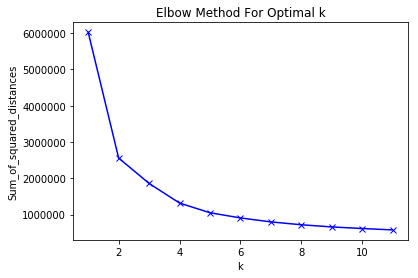

nan

In [41]:
clusterfunctions.kmeans_tworegions(data_tocluster, subsample = 1,robustscalar=True,pca_reduction=True,elbow= True)


8 clusters are selected from the graph. A 10% of data was used to achieve the final classification.

In [ ]:
robusttrans,pca_model, kmeansmodel = clusterfunctions.kmeans_tworegions(data_tocluster,cluster= 8, subsample = 10,robustscalar=True,pca_reduction=True,elbow= False)


In [49]:
## save outputs
## k - means models
filename = 'outputs/kmeansmodelndvi_tworegions.sav'
pickle.dump(kmeansmodel, open(filename, 'wb'))
## robust scalar 
filename = 'outputs/robustscalndvi_tworegions.sav'
pickle.dump(robusttrans, open(filename, 'wb'))
## pca 
filename = 'outputs/pcascalndvi_tworegions.sav'
pickle.dump(pca_model, open(filename, 'wb'))


In [5]:
## checkpoint for cluster

## load models
robusttrans = pickle.load( open( 'outputs/robustscalndvi_tworegions.sav', "rb" ) )
pca_model = pickle.load( open( 'outputs/pcascalndvi_tworegions.sav', "rb" ) )
kmeansmodel = pickle.load( open( 'outputs/kmeansmodelndvi_tworegions.sav', "rb" ) )



In [15]:
#### classy all images

cluster_north = clusterfunctions.classify_oneregion([ndvi_2019_north,ndvi_2018_north,ndvi_2017_north] , 
                                   kmeansmodel, robustscale=robusttrans, pcareduction=pca_model)

cluster_south = clusterfunctions.classify_oneregion([ndvi_2019_south,ndvi_2018_south,ndvi_2017_south] , kmeansmodel,
                                   robustscale=robusttrans, pcareduction=pca_model)

robust
pca
robust
pca


In [17]:
### export the cluster raster
gisfunctions.export_astiff(cluster_north,
              ndvi_2017_north.meta.copy(), 
              path = "outputs", 
              file_name = "clusters_ndvi_north.tif")

gisfunctions.export_astiff(cluster_south,
              ndvi_2017_south.meta.copy(), 
              path = "outputs", 
              file_name = "clusters_ndvi_south.tif")

### remove non crop areas

Plotting the spatial distribution of the clusters, we can note that there are clusters that clearly delineate water surfaces or urban zones. To select which groups belong to agricultural fields, we used two criteriums: 1) supported by a high image resolution, we picked the clusters which overlapped possible crops, 2) because the crop seasonality, we decided to remove those clusters for which the NDVI range presented low values; we use a boxplot graph to visualize the data distribution per each cluster. In the end, we selected the cluster 7. 


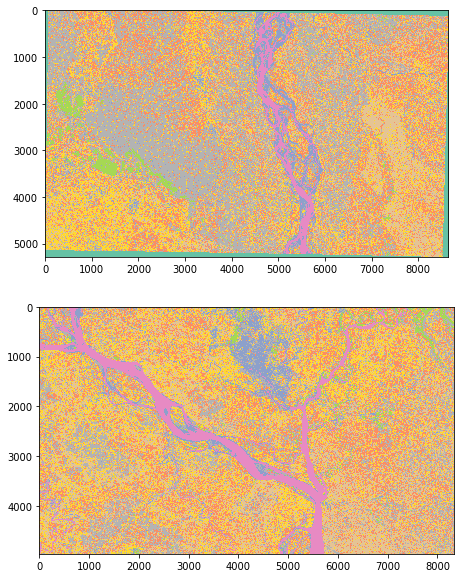

In [24]:
plt.figure(figsize = [14,10])
### plot Clusters

plt.subplot(2, 1, 1)
plt.imshow(cluster_north,cmap=plt.get_cmap('Set2'))

plt.subplot(2, 1, 2)
plt.imshow(cluster_south,cmap=plt.get_cmap('Set2'))


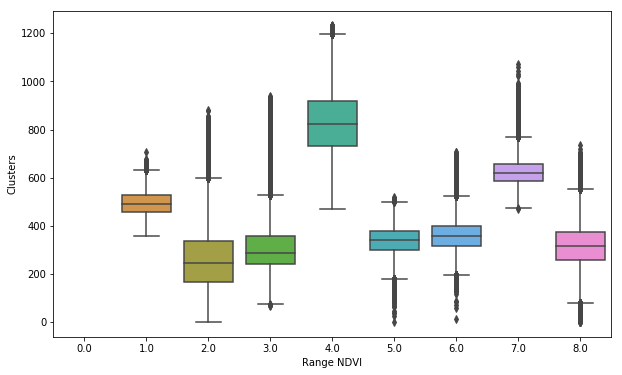

In [49]:
import seaborn as sns
## selct only maximum and minimum data for the three years
data_tocluster = [[ndvi_2019_south,ndvi_2018_south,ndvi_2017_south],
                    [ndvi_2019_north,ndvi_2018_north,ndvi_2017_north]]


ndvidata = pd.concat(
    [pd.concat([pd.DataFrame(gisfunctions.fromrasterio_toflatten(data_tocluster[i][j],selectbands= [3,4])) 
                             for j in range(len(data_tocluster[i]))], axis = 1) 
     for i in range(len(rasteriodata))], axis = 0)

### assign column names
ndvidata.columns = ['max_ndvi19','min_ndvi19','max_ndvi18','min_ndvi18','max_ndvi17','min_ndvi17']

### create a data frame with the new values
databoxplot = pd.DataFrame({'clusters' : np.concatenate((cluster_south.ravel(),cluster_north.ravel())) , 
                            'rangenedvi': ((ndvidata['max_ndvi17'].values - ndvidata['min_ndvi17'].values) + 
              (ndvidata['max_ndvi18'].values - ndvidata['min_ndvi18'].values) +
              (ndvidata['max_ndvi19'].values - ndvidata['min_ndvi19'].values))/3
})

## plot
fig, ax = plt.subplots(figsize=[10,6])
#sns.set_palette("Set2")
plots = sns.boxplot(x="clusters", y="rangenedvi", data=databoxplot , ax = ax)

plots.set(xlabel='Range NDVI', ylabel='Clusters')
del databoxplot
del ndvidata

C:\Users\JANUS\AppData\Local\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys
C:\Users\JANUS\AppData\Local\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice


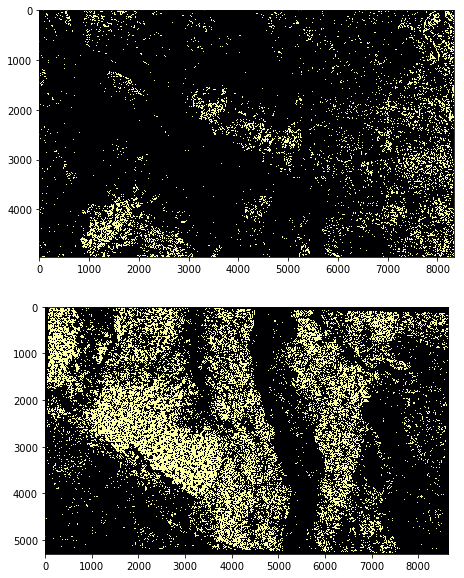

In [73]:
## read minimum vales for the south region
rasterdata = [ndvi_2019_south,ndvi_2018_south,ndvi_2017_south]

ndvidatamin = pd.concat([pd.DataFrame(gisfunctions.fromrasterio_toflatten(rasterdata[j],selectbands= [4])) 
                             for j in range(len(rasterdata))], axis = 1) 

maskmin_values = np.nanmean(ndvidatamin.values, axis = 1)
## create a mask layer
masklayer_south = (maskmin_values>0) * (cluster_south.ravel() == 7)

## read minimum vales for the south region
rasterdata = [ndvi_2019_north,ndvi_2018_north,ndvi_2017_north]

ndvidatamin = pd.concat([pd.DataFrame(gisfunctions.fromrasterio_toflatten(rasterdata[j],selectbands= [4])) 
                             for j in range(len(rasterdata))], axis = 1) 

maskmin_values = np.nanmean(ndvidatamin.values, axis = 1)
masklayer_north = (maskmin_values>0) * (cluster_north.ravel() == 7)

### graphics

plt.figure(figsize = [14,10])
plt.subplot(2, 1, 1)
plt.imshow(masklayer_south.reshape(ndvi_2017_south.shape),cmap=plt.get_cmap('inferno'))


plt.subplot(2, 1, 2)
plt.imshow(masklayer_north.reshape(ndvi_2017_north.shape),cmap=plt.get_cmap('inferno'))



In [74]:
## save the mask layer 
gisfunctions.export_astiff(masklayer_south.reshape(ndvi_2017_south.shape), 
              ndvi_2017_south.meta.copy(),  path = "outputs", file_name = "masklayer_south_.tif")

## save the mask layer 
gisfunctions.export_astiff(masklayer_north.reshape(ndvi_2017_north.shape), 
              ndvi_2017_north.meta.copy(),  path = "outputs", file_name = "masklayer_north_.tif")



## Image Segmentation
<br>
To accuratly detect the crop stress at regional scale, an object based approach was used to calculate the crop healthy reflectance metrics. Although the arsenic levels affect the each crop field, this could eventually been spotted in large extension. For that reason, we implemented superpixel level. The image segmentation was achieved using the Simple Linear Iterative Clustering (SLIC) algorithm. This method was used due to its simplicity for implementation. Two parameters were modified, the number of segments and compactness, which were set up in 300,000 and 50, respectively. Three layers were used as inputs to emulate the RGB channels. In order to use as much information as possible we calculated the average for the standar deaviation, mean and range for three years, these were then normalized and used as red, green, blue channels, respectively.

C:\Users\JANUS\AppData\Local\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.
C:\Users\JANUS\AppData\Local\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app
C:\Users\JANUS\AppData\Local\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
C:\Users\JANUS\AppData\Local\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice
C:\Users\JANUS\AppData\Local\Anaconda3\lib\site-packages\skimage\segmentation\slic_superpixels.py:155: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  segments_z = grid_z[slices]
C:\Users\JANUS\AppData\L

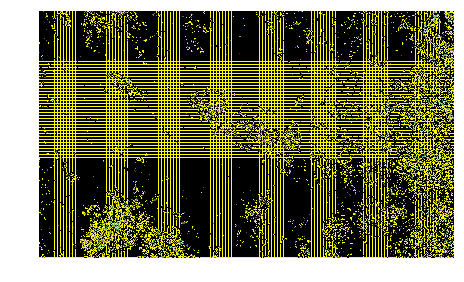

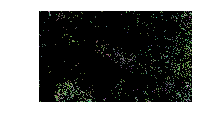

In [113]:
superpixels_south = arsenicmetrics.get_imagesegmentation([ndvi_2017_south,ndvi_2018_south,ndvi_2019_south], 300000, compactness =50,
                                          maskimage="outputs/masklayer_south_.tif") 

C:\Users\JANUS\AppData\Local\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.
C:\Users\JANUS\AppData\Local\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app
C:\Users\JANUS\AppData\Local\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
C:\Users\JANUS\AppData\Local\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice
C:\Users\JANUS\AppData\Local\Anaconda3\lib\site-packages\skimage\segmentation\slic_superpixels.py:155: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  segments_z = grid_z[slices]
C:\Users\JANUS\AppData\L

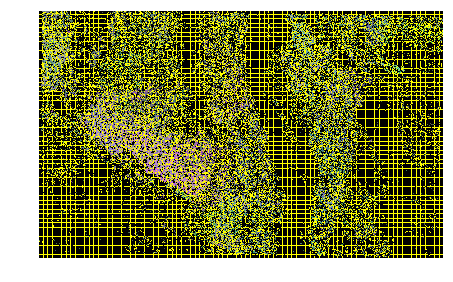

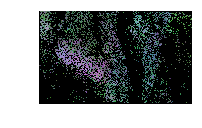

In [115]:
superpixels_north = arsenicmetrics.get_imagesegmentation([ndvi_2017_north,ndvi_2018_northrth,ndvi_2019_north], 300000, compactness =50,
                                          maskimage="outputs/masklayer_north_.tif") 

In [117]:
### check point superpixels

pickle.dump(superpixels_south, open('outputs/superpixels300000_south3years.sav', 'wb'))
pickle.dump(superpixels_north, open('outputs/superpixels300000_north3years.sav', 'wb'))



In [8]:

superpixels_south = pickle.load( open('outputs/superpixels300000_south3years.sav', 'rb'))
superpixels_north = pickle.load( open('outputs/superpixels300000_north3years.sav', 'rb'))



## Healthy crops metrics

To identify stressed crops on a regional scale, we calculated two features based on the maximum vegetation indexes (VI) values obtained during the three years seasons. The mean metric was used to reduce the values for each superpixel per time.  To get a reliable representation of crop presence in the superpixels, only those superpixels with more than 40 percent of data were used to compute the metrics. The mean values were then transformed into two features: the first feature was the averaged of the three years, and the second was the slope derivated from a linear regression function that fit the three maximum values obtained for each year.
    
<br>
<br>
$$ VI_{max}= \frac{ \frac{\sum_{i=1}^{p}(VI_{max i} 2017)}{p} \ + \ \frac{\sum_{i=1}^{p}(VI_{max i} 2018)}{p} +  \ \frac{\sum_{i=1}^{p}(VI_{max i} 2019)}{p}}{3} $$ 

<br>
<br>

$$ f(x)=  slope VI(max) * X + a$$ 
<br>
$$ where\  X = {(VI_{max i} 2017), (VI_{max i} 2018), (VI_{max i} 2019)} $$ 


### NDVI metrics

In [193]:

NDVI_north = arsenicmetrics.get_healthmetrics([ndvi_2017_north,ndvi_2018_north,ndvi_2019_north],
                               superpixels_north, "outputs/masklayer_north_.tif",band_number = 3)
NDVI_south = arsenicmetrics.get_healthmetrics([ndvi_2017_south,ndvi_2018_south,ndvi_2019_south],
                               superpixels_south, "outputs/masklayer_south_.tif",band_number = 3)

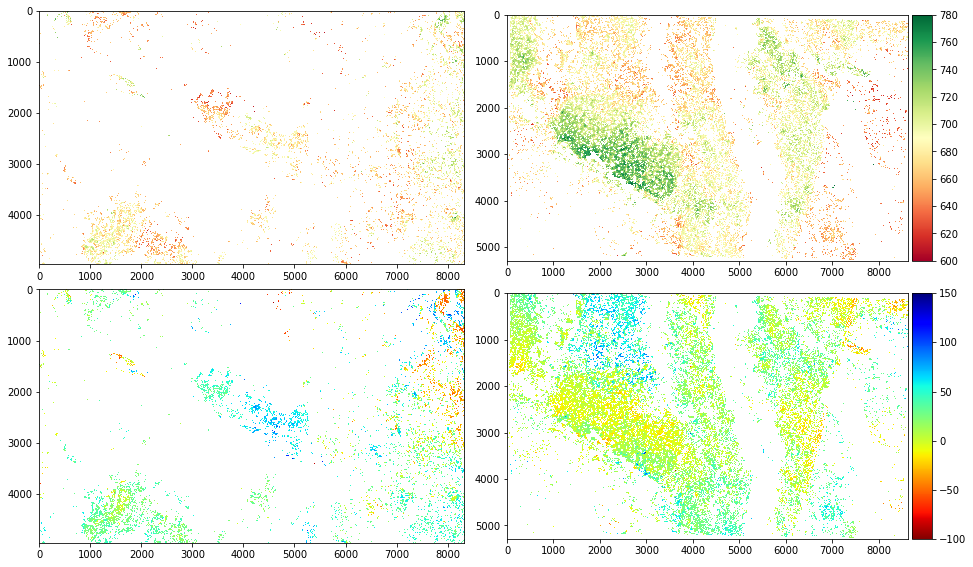

In [52]:
### plot
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig = plt.figure(figsize= [16,10])
fig.subplots_adjust(hspace=0.05, wspace=0.1)

ax = fig.add_subplot(2, 2, 1)
ax.imshow(NDVI_south[0],vmax = 780,vmin = 600,cmap='RdYlGn')
divider = make_axes_locatable(ax)

ax = fig.add_subplot(2, 2, 2)
im = ax.imshow(NDVI_north[0],vmax = 780,vmin = 600,cmap='RdYlGn')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im, cax=cax)

ax = fig.add_subplot(2, 2, 3)
ax.imshow(NDVI_south[1],vmax = 150,vmin = -100,cmap='jet_r')
divider = make_axes_locatable(ax)

ax = fig.add_subplot(2, 2, 4)
im = ax.imshow(NDVI_north[1],vmax = 150,vmin = -100,cmap='jet_r')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im, cax=cax)

In [197]:
### check ndvi metrics

pickle.dump(NDVI_south, open('outputs/ndvimetrics_south.sav', 'wb'))
pickle.dump(NDVI_north, open('outputs/ndvimetrics_north.sav', 'wb'))


In [6]:
NDVI_south = pickle.load(open('outputs/ndvimetrics_south.sav', 'rb'))
NDVI_north = pickle.load(open('outputs/ndvimetrics_north.sav', 'rb'))


In [26]:
## export health metrics

gisfunctions.export_astiff(NDVI_north[0].astype(np.float32),
              ndvi_2017_north.meta.copy(), 
              path = "outputs", 
              file_name = "NDVI17_19_max_north.tif",d_type = 'float32')

gisfunctions.export_astiff(NDVI_north[1].astype(np.float32),
              ndvi_2017_north.meta.copy(), 
              path = "outputs", 
              file_name = "NDVI17_19_slope_north.tif",d_type = 'float32')

gisfunctions.export_astiff(NDVI_south[0].astype(np.float32),
              ndvi_2017_south.meta.copy(), 
              path = "outputs", 
              file_name = "NDVI17_19_max_south.tif",d_type = 'float32')

gisfunctions.export_astiff(NDVI_south[1].astype(np.float32),
              ndvi_2017_south.meta.copy(), 
              path = "outputs", 
              file_name = "NDVI17_19_slope_south.tif",d_type = 'float32')

### NDRE metrics

Liu et al reported the effectiveness to montir stress levels at regional scale. The masked layer created for NDVI was used to mask th NDRE data.

In [27]:
#### read every NDVI composite image
## each layer is composited by: the standar deviation, mean, maximum and minimum valies for the time screening

ndre_2019_south = rasterio.open("gee_data/NDRE_2018_2019_south.tif")
ndre_2018_south = rasterio.open("gee_data/NDRE_2017_2018_south.tif")
ndre_2017_south = rasterio.open("gee_data/NDRE_2016_2017_south.tif")

## std_ndvi mean_ndvi max_ndvi min_ndvi
ndre_2019_north = rasterio.open("gee_data/NDRE_2018_2019_north.tif")
ndre_2018_north = rasterio.open("gee_data/NDRE_2017_2018_north.tif")
ndre_2017_north = rasterio.open("gee_data/NDRE_2016_2017_north.tif")



In [28]:
### calculate metrics

NDRE_south = arsenicmetrics.get_healthmetrics([ndre_2017_south,ndre_2018_south,ndre_2019_south], superpixels_south, "outputs/masklayer_south_.tif",band_number = 3)
NDRE_north = arsenicmetrics.get_healthmetrics([ndre_2017_north,ndre_2018_north,ndre_2019_north], superpixels_north, "outputs/masklayer_north_.tif",band_number = 3)


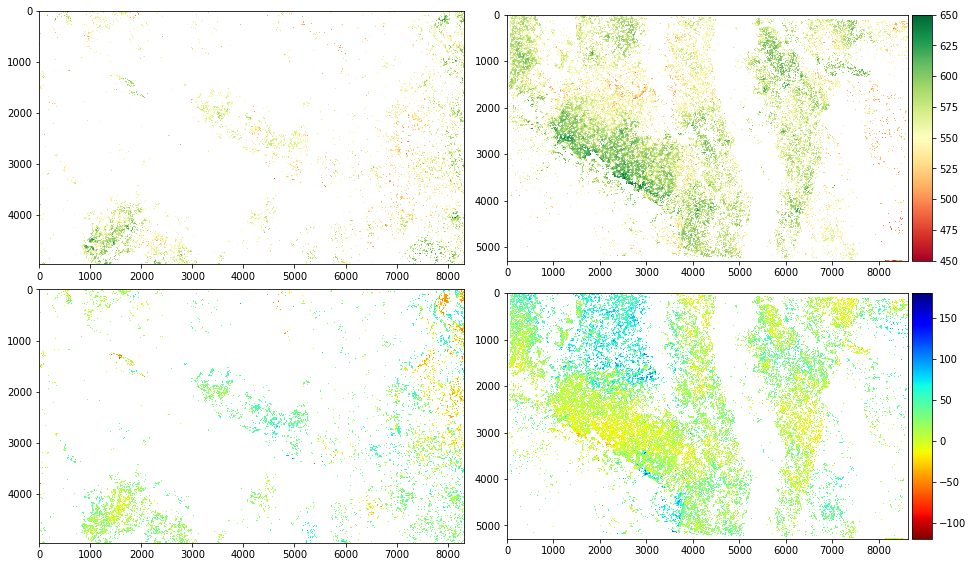

In [47]:
### plot
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig = plt.figure(figsize= [16,10])
fig.subplots_adjust(hspace=0.05, wspace=0.1)

ax = fig.add_subplot(2, 2, 1)
ax.imshow(NDRE_south[0],vmax = 650,vmin = 450,cmap='RdYlGn')
divider = make_axes_locatable(ax)

ax = fig.add_subplot(2, 2, 2)
im = ax.imshow(NDRE_north[0],vmax = 650,vmin = 450,cmap='RdYlGn')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im, cax=cax)

ax = fig.add_subplot(2, 2, 3)
ax.imshow(NDRE_south[1],vmax = 180,vmin = -120,cmap='jet_r')
divider = make_axes_locatable(ax)

ax = fig.add_subplot(2, 2, 4)
im = ax.imshow(NDRE_north[1],vmax = 180,vmin = -120,cmap='jet_r')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im, cax=cax)

In [ ]:
### check ndvi metrics

pickle.dump(NDRE_south, open('outputs/ndremetrics_south.sav', 'wb'))
pickle.dump(NDRE_north, open('outputs/ndremetrics_north.sav', 'wb'))

In [8]:
NDRE_south = pickle.load(open('outputs/ndremetrics_south.sav', 'rb'))
NDRE_north = pickle.load(open('outputs/ndremetrics_north.sav', 'rb'))


In [49]:
## export health metrics

gisfunctions.export_astiff(NDRE_north[0].astype(np.float32),
              ndre_2017_north.meta.copy(), 
              path = "outputs", 
              file_name = "NDRE17_19_max_north.tif",d_type = 'float32')

gisfunctions.export_astiff(NDRE_north[1].astype(np.float32),
              ndre_2017_north.meta.copy(), 
              path = "outputs", 
              file_name = "NDRE17_19_slope_north.tif",d_type = 'float32')

gisfunctions.export_astiff(NDRE_south[0].astype(np.float32),
              ndre_2017_south.meta.copy(), 
              path = "outputs", 
              file_name = "NDRE17_19_max_south.tif",d_type = 'float32')

gisfunctions.export_astiff(NDRE_south[1].astype(np.float32),
              ndre_2017_south.meta.copy(), 
              path = "outputs", 
              file_name = "NDRE17_19_slope_south.tif",d_type = 'float32')


## Density Plots

In [ ]:


north_values = pd.DataFrame({'maxndre': NDRE_north[0].ravel(),'slopendre': NDRE_north[1].ravel(),
                                 'maxndvi': NDVI_north[0].ravel(),'slopendvi': NDVI_north[1].ravel(),
                                 'region': 'north'})

south_values = pd.DataFrame({'maxndre': NDRE_south[0].ravel(),'slopendre': NDRE_south[1].ravel(),
                                 'maxndvi': NDVI_south[0].ravel(),'slopendvi': NDVI_south[1].ravel(),
                                 'region': 'south'})

north_values = north_values.dropna()
south_values = south_values.dropna()

C:\Users\JANUS\AppData\Local\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


[Text(0,0.5,'Density'), Text(0.5,0,'Vegetation Index Value * 1000')]

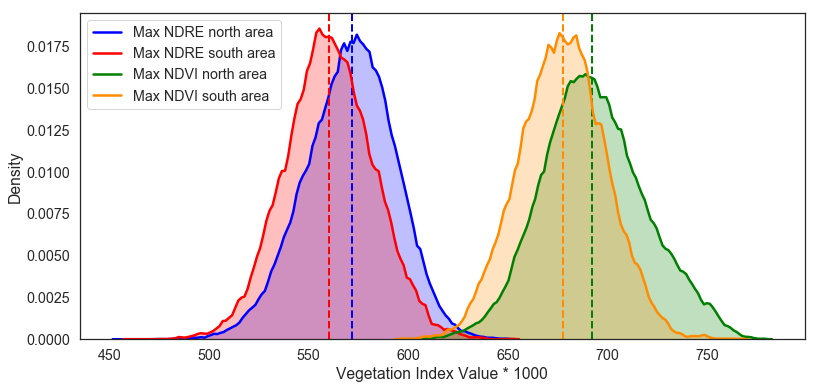

In [41]:
## ndre maximum
import seaborn as sns


ndre_max = pd.DataFrame({'maxndre_north': NDRE_north[0].ravel(),'slopendre_south': NDRE_north[1].ravel()})

#sns.jointplot(x=ndre_max["maxndre_north"], y=ndre_max["slopendre_south"], kind='kde')
fig, ax = plt.subplots(figsize=[13,6])
sns.set_style("white")

sns.set_context("notebook", font_scale=1.3, rc={"lines.linewidth": 2.5})

p1=sns.kdeplot(north_values['maxndre'], shade=True, color="b",ax = ax, label = 'Max NDRE north area')
p1.axvline(north_values.maxndre.median(), color='b', linestyle='--', lw=2)

p1=sns.kdeplot(south_values['maxndre'], shade=True, color="r",ax = ax, label = 'Max NDRE south area')
p1.axvline(south_values.maxndre.median(), color='r', linestyle='--', lw=2)

p1=sns.kdeplot(north_values['maxndvi'], shade=True, color="g",ax = ax, label = 'Max NDVI north area')
p1.axvline(north_values.maxndvi.median(), color='g', linestyle='--', lw=2)

p1=sns.kdeplot(south_values['maxndvi'], shade=True, color="darkorange",ax = ax, label = 'Max NDVI south area')
p1.axvline(south_values.maxndvi.median(), color='darkorange', linestyle='--', lw=2)

p1.set(xlabel='Vegetation Index Value * 1000', ylabel='Density')

C:\Users\JANUS\AppData\Local\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


[Text(0,0.5,'Density'), Text(0.5,0,'Slope')]

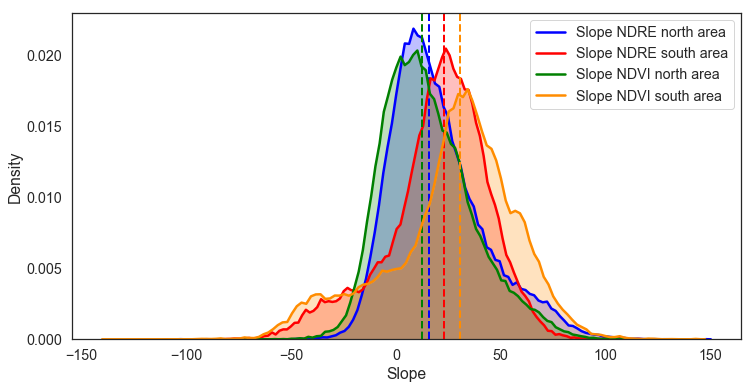

In [42]:
fig, ax = plt.subplots(figsize=[12,6])
sns.set_style("white")

sns.set_context("notebook", font_scale=1.3, rc={"lines.linewidth": 2.5})

p1=sns.kdeplot(north_values['slopendre'], shade=True, color="b",ax = ax, label = 'Slope NDRE north area')
p1.axvline(north_values.slopendre.median(), color='b', linestyle='--', lw=2)
p1=sns.kdeplot(south_values['slopendre'], shade=True, color="r",ax = ax, label = 'Slope NDRE south area')
p1.axvline(south_values.slopendre.median(), color='r', linestyle='--', lw=2)


p1=sns.kdeplot(north_values['slopendvi'], shade=True, color="g",ax = ax, label = 'Slope NDVI north area')
p1.axvline(north_values.slopendvi.median(), color='g', linestyle='--', lw=2)
p1=sns.kdeplot(south_values['slopendvi'], shade=True, color="darkorange",ax = ax, label = 'Slope NDVI south area')
p1.axvline(south_values.slopendvi.median(), color='darkorange', linestyle='--', lw=2)

p1.set(xlabel='Slope', ylabel='Density')

In [35]:
north_values.dropna().to_csv("outputs/northvalues.csv")
south_values.dropna().to_csv("outputs/southvalues.csv")